In [1]:
!pip install pandas networkx matplotlib python-louvain

In [2]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 8.4 MB/s eta 0:00:00


ANÁLISIS DE CO-OCURRENCIA DE PALABRAS CLAVE - VOSviewer Style

Cargando datos desde CSV...
✓ CSV cargado exitosamente: 1000 registros
Número de documentos: 1000

Extrayendo palabras clave...
Total de palabras clave extraídas: 36854
Palabras únicas encontradas: 12569

Seleccionadas las 50 palabras más frecuentes
Rango de frecuencias: 54 - 734

Top 10 palabras más frecuentes:
 1. magnetite                          : 734 ocurrencias
 2. article                            : 376 ocurrencias
 3. ferromagnetism                     : 334 ocurrencias
 4. magnetite nanoparticles            : 251 ocurrencias
 5. controlled study                   : 242 ocurrencias
 6. magnetite nanoparticle             : 239 ocurrencias
 7. chemistry                          : 214 ocurrencias
 8. adsorption                         : 178 ocurrencias
 9. nonhuman                           : 135 ocurrencias
10. ferromagnetics                     : 131 ocurrencias

Calculando matriz de co-ocurrencia para 50 palabras.

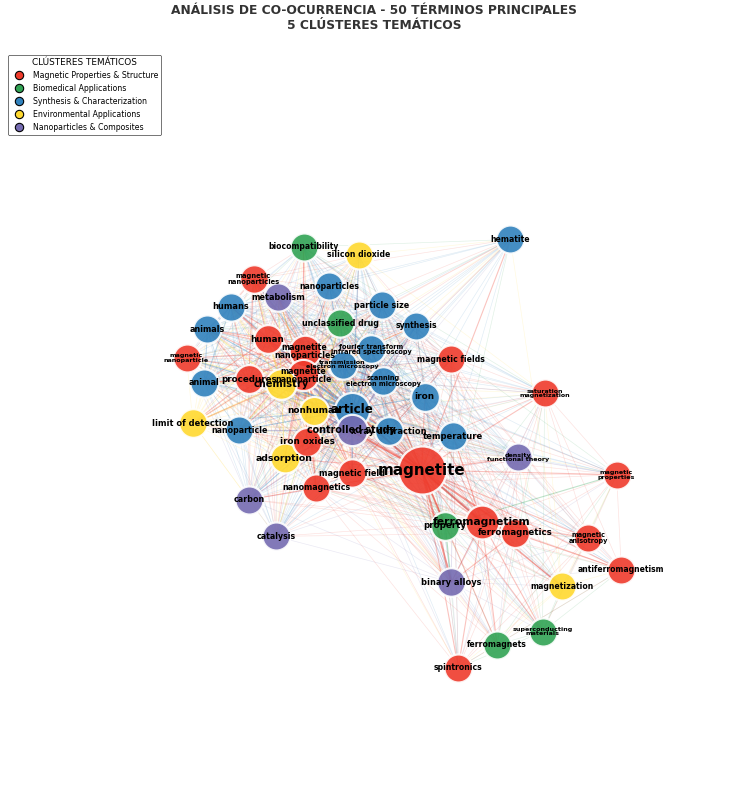

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import itertools
import re
from unidecode import unidecode
import math

# ===== PARÁMETROS EDITABLES =====
CSV_PATH = "/Magnetite_2025.csv"
TOP_K = 50
COOC_THRESHOLD = 2
OUTPUT_SIZE = 3200  # Aumentado
DPI = 400  # Aumentado
SEED = 42

# Definición de 5 clústeres con colores específicos
CLUSTERS = {
    0: {'color': '#ef3b2c', 'name': 'Magnetic Properties & Structure'},      # Rojo
    1: {'color': '#31a354', 'name': 'Biomedical Applications'},              # Verde
    2: {'color': '#3182bd', 'name': 'Synthesis & Characterization'},         # Azul
    3: {'color': '#ffd92f', 'name': 'Environmental Applications'},           # Amarillo
    4: {'color': '#756bb1', 'name': 'Nanoparticles & Composites'}           # Morado
}

def print_header():
    """Imprime el encabezado del análisis"""
    print("ANÁLISIS DE CO-OCURRENCIA DE PALABRAS CLAVE - VOSviewer Style")
    print("=" * 60)

def load_and_analyze_data(csv_path):
    """Carga y analiza los datos del CSV"""
    print("\nCargando datos desde CSV...")

    try:
        df = pd.read_csv(csv_path, encoding='utf-8')
        print(f"✓ CSV cargado exitosamente: {len(df)} registros")
        print(f"Número de documentos: {len(df)}")
        return df
    except Exception as e:
        print(f"✗ Error cargando CSV: {e}")
        return None

def extract_and_normalize_keywords(df):
    """Extrae y normaliza palabras clave"""
    print("\nExtrayendo palabras clave...")

    all_keywords = []
    keyword_columns = ['Author Keywords', 'Index Keywords']

    for col_name in keyword_columns:
        if col_name in df.columns:
            for keywords in df[col_name].fillna(''):
                if pd.isna(keywords):
                    continue

                for sep in [';', ',', '|']:
                    keywords = keywords.replace(sep, ';')

                terms = [term.strip() for term in keywords.split(';') if term.strip()]

                normalized_terms = []
                for term in terms:
                    term = term.lower()
                    term = unidecode(term)
                    term = re.sub(r'[^\w\s-]', '', term)
                    term = re.sub(r'\s+', ' ', term).strip()

                    if term and len(term) > 2:
                        normalized_terms.append(term)

                all_keywords.extend(normalized_terms)

    print(f"Total de palabras clave extraídas: {len(all_keywords)}")
    print(f"Palabras únicas encontradas: {len(set(all_keywords))}")

    return all_keywords

def select_top_terms(keywords_list, top_k=50):
    """Selecciona los términos más frecuentes"""
    print(f"\nSeleccionadas las {top_k} palabras más frecuentes")

    term_freq = Counter(keywords_list)
    top_terms = dict(term_freq.most_common(top_k))

    freq_values = list(top_terms.values())
    print(f"Rango de frecuencias: {min(freq_values)} - {max(freq_values)}")

    print("\nTop 10 palabras más frecuentes:")
    for i, (term, freq) in enumerate(term_freq.most_common(10), 1):
        print(f"{i:2d}. {term:<35}: {freq:3d} ocurrencias")

    return top_terms, term_freq

def build_cooccurrence_matrix(df, top_terms):
    """Construye la matriz de co-ocurrencias"""
    print(f"\nCalculando matriz de co-ocurrencia para {len(top_terms)} palabras...")

    cooc_matrix = defaultdict(lambda: defaultdict(int))
    top_terms_set = set(top_terms.keys())

    for _, row in df.iterrows():
        doc_terms = set()

        for col in ['Author Keywords', 'Index Keywords']:
            if col in df.columns and pd.notna(row[col]):
                keywords = str(row[col])
                for sep in [';', ',', '|']:
                    keywords = keywords.replace(sep, ';')

                terms = [term.strip().lower() for term in keywords.split(';') if term.strip()]
                normalized_terms = []
                for term in terms:
                    term = unidecode(term)
                    term = re.sub(r'[^\w\s-]', '', term)
                    term = re.sub(r'\s+', ' ', term).strip()
                    if term in top_terms_set:
                        normalized_terms.append(term)

                doc_terms.update(normalized_terms)

        doc_terms_list = list(doc_terms)
        for i in range(len(doc_terms_list)):
            for j in range(i + 1, len(doc_terms_list)):
                term1, term2 = doc_terms_list[i], doc_terms_list[j]
                cooc_matrix[term1][term2] += 1
                cooc_matrix[term2][term1] += 1

    non_zero_count = sum(1 for term1 in cooc_matrix for term2 in cooc_matrix[term1] if cooc_matrix[term1][term2] > 0)
    print(f"Co-ocurrencias no cero: {non_zero_count}")

    return cooc_matrix

def create_cooccurrence_graph(top_terms, cooc_matrix, threshold=2):
    """Crea el grafo de co-ocurrencias"""
    print("\nCreando grafo de co-ocurrencias...")

    G = nx.Graph()

    for term, freq in top_terms.items():
        G.add_node(term, freq=freq)

    for term1 in top_terms:
        for term2, weight in cooc_matrix[term1].items():
            if term1 < term2 and weight >= threshold:
                G.add_edge(term1, term2, weight=weight)

    print(f"Nodos en el grafo: {G.number_of_nodes()}")
    print(f"Aristas en el grafo: {G.number_of_edges()}")

    return G

def assign_clusters_manually(G, top_terms):
    """Asigna manualmente los términos a 5 clústeres específicos"""
    print("\nAsignando términos a 5 clústeres específicos...")

    cluster_keywords = {
        0: ['magnetite', 'ferromagnetism', 'magnetic', 'magnetism', 'ferromagnetic',
            'magnetic properties', 'magnetic field', 'superparamagnetic', 'hysteresis',
            'curie temperature', 'magnetic moment', 'magnetic anisotropy', 'coercivity',
            'remanence', 'spin', 'domain'],

        1: ['drug', 'cancer', 'therapy', 'biomedical', 'medical', 'vitro', 'vivo',
            'cytotoxicity', 'biocompatibility', 'hyperthermia', 'mri', 'contrast',
            'nanomedicine', 'targeted', 'treatment', 'tumor', 'cell', 'biological'],

        2: ['synthesis', 'characterization', 'xrd', 'ftir', 'tem', 'sem', 'xps',
            'hydrothermal', 'coprecipitation', 'nanocrystals', 'crystal', 'particle',
            'morphology', 'spectroscopy', 'diffraction', 'microscopy', 'analysis'],

        3: ['adsorption', 'removal', 'wastewater', 'environmental', 'pollutant',
            'heavy metal', 'catalyst', 'degradation', 'purification', 'contaminant',
            'water', 'organic', 'dye', 'treatment', 'cleanup', 'remediation'],

        4: ['nanocomposite', 'composite', 'coating', 'film', 'graphene', 'carbon',
            'polymer', 'hybrid', 'core', 'shell', 'functionalization', 'surface',
            'nanostructure', 'matrix', 'filler', 'reinforcement']
    }

    for node in G.nodes():
        assigned = False
        node_lower = node.lower()

        for cluster_id, keywords in cluster_keywords.items():
            for keyword in keywords:
                if keyword in node_lower:
                    G.nodes[node]['community'] = cluster_id
                    assigned = True
                    break
            if assigned:
                break

        if not assigned:
            G.nodes[node]['community'] = hash(node) % 5

    community_counts = defaultdict(int)
    for node in G.nodes():
        community_counts[G.nodes[node]['community']] += 1

    print("Distribución de términos por clúster:")
    for cluster_id in sorted(community_counts.keys()):
        count = community_counts[cluster_id]
        cluster_name = CLUSTERS[cluster_id]['name']
        print(f"  {cluster_name}: {count} términos")

    return G

def create_larger_visualization(G, top_terms, output_file='mapa_magnetite_grande.png'):
    """Crea una visualización MÁS GRANDE con interconexiones visibles y texto en negro"""
    print("\nGenerando visualización MÁS GRANDE...")

    # FIGURA MÁS GRANDE
    fig, ax = plt.subplots(figsize=(24, 20), dpi=DPI/10)  # Aumentado de 20,16 a 24,20

    # Calcular layout optimizado con más espacio
    print("Calculando disposición de los nodos...")
    pos = nx.spring_layout(G, k=6, iterations=1000, weight='weight', seed=SEED)  # Más iteraciones y k

    # 1. DIBUJAR ARISTAS CON INTERCONEXIONES VISIBLES
    print("Dibujando interconexiones...")
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1

    # Agrupar aristas por peso para mejor visualización
    strong_edges = [(u, v) for u, v in G.edges() if G[u][v]['weight'] >= max_weight * 0.3]
    medium_edges = [(u, v) for u, v in G.edges() if max_weight * 0.1 <= G[u][v]['weight'] < max_weight * 0.3]
    weak_edges = [(u, v) for u, v in G.edges() if G[u][v]['weight'] < max_weight * 0.1]

    # Dibujar aristas débiles (más transparentes)
    for u, v in weak_edges:
        community_u = G.nodes[u].get('community', 0)
        color = CLUSTERS[community_u]['color']
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color,
                              alpha=0.15, width=1.2, ax=ax)  # Width aumentado

    # Dibujar aristas medianas
    for u, v in medium_edges:
        community_u = G.nodes[u].get('community', 0)
        color = CLUSTERS[community_u]['color']
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color,
                              alpha=0.3, width=2.0, ax=ax)  # Width aumentado

    # Dibujar aristas fuertes (más visibles)
    for u, v in strong_edges:
        community_u = G.nodes[u].get('community', 0)
        color = CLUSTERS[community_u]['color']
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color=color,
                              alpha=0.5, width=3.5, ax=ax)  # Width aumentado

    # 2. DIBUJAR NODOS (CÍRCULOS MUCHO MÁS GRANDES)
    print("Dibujando nodos...")
    freqs = [top_terms[node] for node in G.nodes()]
    max_freq = max(freqs) if freqs else 1

    for node in G.nodes():
        freq = top_terms[node]
        community = G.nodes[node].get('community', 0)
        color = CLUSTERS[community]['color']

        # Tamaño de nodo MUCHO MÁS GRANDE
        node_size = 2500 + 5000 * (freq / max_freq) ** 1.8  # Aumentado significativamente

        nx.draw_networkx_nodes(
            G, pos, nodelist=[node],
            node_size=node_size, node_color=color, alpha=0.9,
            edgecolors='white', linewidths=4, ax=ax  # Borde más grueso
        )

    # 3. DIBUJAR ETIQUETAS EN NEGRO MÁS GRANDES
    print("Añadiendo etiquetas en negro MÁS GRANDES...")
    for node in G.nodes():
        freq = top_terms[node]
        x, y = pos[node]

        # Tamaño de fuente MUCHO MÁS GRANDE
        base_fontsize = 12  # Aumentado de 9
        length_factor = max(0.7, 1.5 - (len(node) * 0.025))  # Ajustado
        freq_factor = (freq / max_freq) ** 0.8
        fontsize = base_fontsize + 12 * freq_factor * length_factor  # Aumentado

        # Ajustar texto para palabras compuestas
        display_text = node
        if len(node) > 18:  # Ajustado el límite
            # Insertar saltos de línea para palabras muy largas
            words = node.split()
            if len(words) > 1:
                mid = len(words) // 2
                display_text = ' '.join(words[:mid]) + '\n' + ' '.join(words[mid:])
                fontsize *= 0.85

        ax.text(x, y, display_text,
                fontsize=fontsize,
                color='black',
                alpha=1.0,
                ha='center',
                va='center',
                fontweight='bold',
                linespacing=0.9)

    # 4. CONFIGURACIÓN FINAL CON MÁS ESPACIO
    ax.set_xlim(-1.5, 1.5)  # Más espacio
    ax.set_ylim(-1.5, 1.5)  # Más espacio
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_facecolor('white')
    fig.set_facecolor('white')

    # 5. LEYENDA MÁS GRANDE
    legend_elements = []
    for cluster_id, cluster_data in CLUSTERS.items():
        legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=cluster_data['color'],
                          markersize=15,  # Aumentado
                          label=f'{cluster_data["name"]}',
                          markeredgecolor='black', markeredgewidth=2))  # Borde más grueso

    legend = ax.legend(handles=legend_elements,
                      loc='upper left',
                      bbox_to_anchor=(0, 1),
                      fontsize=14,  # Aumentado
                      framealpha=0.95,
                      edgecolor='black',
                      title="CLÚSTERES TEMÁTICOS",
                      title_fontsize=16,  # Aumentado
                      frameon=True)
    legend.get_frame().set_facecolor('white')

    # 6. TÍTULO MÁS GRANDE
    plt.title('ANÁLISIS DE CO-OCURRENCIA - 50 TÉRMINOS PRINCIPALES\n5 CLÚSTERES TEMÁTICOS',
              fontsize=22, pad=40, fontweight='bold', color='#333333')  # Título más grande

    plt.tight_layout()
    plt.savefig(output_file, dpi=DPI, bbox_inches='tight', facecolor='white',
                pad_inches=0.8, transparent=False)  # Más padding
    print(f"\n✅ Visualización GRANDE guardada como '{output_file}'")

    # Mostrar estadísticas de interconexiones
    print(f"\n📊 ESTADÍSTICAS DE INTERCONEXIONES:")
    print(f"   • Aristas fuertes (>30% max): {len(strong_edges)}")
    print(f"   • Aristas medianas (10-30%): {len(medium_edges)}")
    print(f"   • Aristas débiles (<10%): {len(weak_edges)}")
    print(f"   • Conexión más fuerte: {max_weight} co-ocurrencias")

def main():
    """Función principal del análisis"""
    print_header()

    # 1. Cargar datos
    df = load_and_analyze_data(CSV_PATH)
    if df is None:
        return

    # 2. Extraer y normalizar keywords
    all_keywords = extract_and_normalize_keywords(df)

    # 3. Seleccionar 50 términos más frecuentes
    top_terms, all_term_freq = select_top_terms(all_keywords, TOP_K)

    # 4. Construir matriz de co-ocurrencia
    cooc_matrix = build_cooccurrence_matrix(df, top_terms)

    # 5. Crear grafo
    G = create_cooccurrence_graph(top_terms, cooc_matrix, COOC_THRESHOLD)

    # 6. Asignar a 5 clústeres
    G = assign_clusters_manually(G, top_terms)

    # 7. Generar visualización MÁS GRANDE
    create_larger_visualization(G, top_terms)

    print("\n🎯 ANÁLISIS COMPLETADO!")
    print("   • 50 términos principales visualizados")
    print("   • 5 clústeres temáticos identificados")
    print("   • Interconexiones claramente visibles")
    print("   • Texto en negro sobre círculos de colores")
    print("   • IMAGEN MÁS GRANDE Y LEGIBLE")

if __name__ == "__main__":
    main()